In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 

from ipynb_path import *

In [16]:
from counterfactual.import_essentials import *
from counterfactual.evaluate import load_trained_model, model_cf_gen
from counterfactual.net import AdvCounterfactualModel
from counterfactual.adversarial_experiment import *
from tqdm.notebook import tqdm

# plt.style.use(['science', 'bright'])
plt.style.use(['science',  'vibrant'])
# plt.style.use(['ieee'])



In [3]:
import wandb
run = wandb.init()


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: birkhoffg (use `wandb login --relogin` to force relogin)


In [4]:
validity_changes_linear = [ 
    run.use_artifact('birkhoffg/adv-counternet/run-1zyakm2c-ValidityChanges:v0', type='run_table').download(),
    run.use_artifact('birkhoffg/adv-counternet/run-jh6lfcjq-ValidityChanges:v0', type='run_table').download(),
    run.use_artifact('birkhoffg/adv-counternet/run-3ghyhzin-ValidityChanges:v0', type='run_table').download(),
    run.use_artifact('birkhoffg/adv-counternet/run-1il2lydk-ValidityChanges:v0', type='run_table').download(),
    run.use_artifact('birkhoffg/adv-counternet/run-3vjwv2as-ValidityChanges:v0', type='run_table').download(), 
    run.use_artifact('birkhoffg/adv-counternet/run-1mknvgq2-ValidityChanges:v0', type='run_table').download(), 
    run.use_artifact('birkhoffg/adv-counternet/run-2f0yxgo3-ValidityChanges:v0', type='run_table').download(), 
    run.use_artifact('birkhoffg/adv-counternet/run-m4t1grl8-ValidityChanges:v0', type='run_table').download(), 
    # run.use_artifact('birkhoffg/adv-counternet/run-3kggohy1-ValidityChanges:v0', type='run_table').download(), 
]
# n_steps = [1, 2, 3, 5]

In [5]:
validity_changes_static = [ 
    run.use_artifact('birkhoffg/adv-counternet/run-2u73q7yx-ValidityChanges:v0', type='run_table').download(),
    run.use_artifact('birkhoffg/adv-counternet/run-r4m3f6fm-ValidityChanges:v0', type='run_table').download(),
    run.use_artifact('birkhoffg/adv-counternet/run-1pynthhc-ValidityChanges:v0', type='run_table').download(),
    run.use_artifact('birkhoffg/adv-counternet/run-u79zhdfa-ValidityChanges:v0', type='run_table').download(),
    run.use_artifact('birkhoffg/adv-counternet/run-3085edfl-ValidityChanges:v0', type='run_table').download(),
    run.use_artifact('birkhoffg/adv-counternet/run-2q8utnfu-ValidityChanges:v0', type='run_table').download(),
    run.use_artifact('birkhoffg/adv-counternet/run-1vztvcsv-ValidityChanges:v0', type='run_table').download(),
    run.use_artifact('birkhoffg/adv-counternet/run-3l50okvd-ValidityChanges:v0', type='run_table').download()
]
n_steps = [1, 2, 3, 5, 7, 10, 13, 15]

In [6]:
def path2df(x):
    with open(Path(x) / 'Validity Changes.table.json')  as f:
        cf_metrics = json.load(f)
        return pd.DataFrame(data=cf_metrics['data'], columns=cf_metrics['columns']).set_index('stat')

validity_changes_linear_dfs = list(map(path2df, validity_changes_linear))
# assert len(validity_changes_linear_dfs) == len(n_steps)

In [7]:
validity_changes_linear_dfs[2]

,cf_validity,cf_validity (w=1),cf_validity (all),validity_decrease (w=1),validity_decrease (all)
stat,,,,,
mean,0.972160,0.905555,0.885447,0.066178,0.086713
std,0.041385,0.133777,0.164040,0.116100,0.156186


In [8]:
validity_changes_static_dfs = list(map(path2df, validity_changes_static))
assert len(validity_changes_static_dfs) == len(n_steps)

In [9]:
validity_changes_linear_dfs[0]

,cf_validity,cf_validity (w=1),cf_validity (all),validity_decrease (w=1),validity_decrease (all)
stat,,,,,
mean,0.957973,0.916165,0.878120,0.041186,0.079853
std,0.056608,0.116001,0.167486,0.091359,0.171207


In [12]:
def plot_scheduler_comparision(n_steps, 
                               validity_changes_linear_dfs, 
                               validity_changes_static_dfs,
                               col_name = "cf_validity (all)",
                               y_label = "Robust Validity"):
    fig, ax = plt.subplots()
    validity_change_linear_list = np.array([df[col_name]['mean'] for df in validity_changes_linear_dfs])
    validity_change_static_list = np.array([df[col_name]['mean'] for df in validity_changes_static_dfs])
    validity_change_linear_std_list = [df[col_name]['std'] for df in validity_changes_linear_dfs]
    validity_change_static_std_list = [df[col_name]['std'] for df in validity_changes_linear_dfs]
    x = np.arange(len(n_steps))  # the label locations
    width = 0.35  # the width of the bars

    print(np.mean(validity_change_linear_list[:6] - validity_change_static_list[:6]))
    rects1 = ax.bar(x - width/2, validity_change_linear_list, width, 
                    # yerr=validity_change_linear_std_list, capsize=5, 
                    label='linear')
    rects2 = ax.bar(x + width/2, validity_change_static_list, width, 
                    # yerr=validity_change_static_std_list, capsize=5, 
                    label='static')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Attacker Steps')
    ax.set_ylabel(y_label)
    ax.set_ylim((0.8, 1.0))
    # ax.set_title('Rob')
    ax.set_xticks(x)
    ax.set_xticklabels([str(n) for n in n_steps])
    ax.legend()
    return fig

    # ax.bar_label(rects1, padding=3)
    # ax.bar_label(rects2, padding=3)


0.007915023331426926


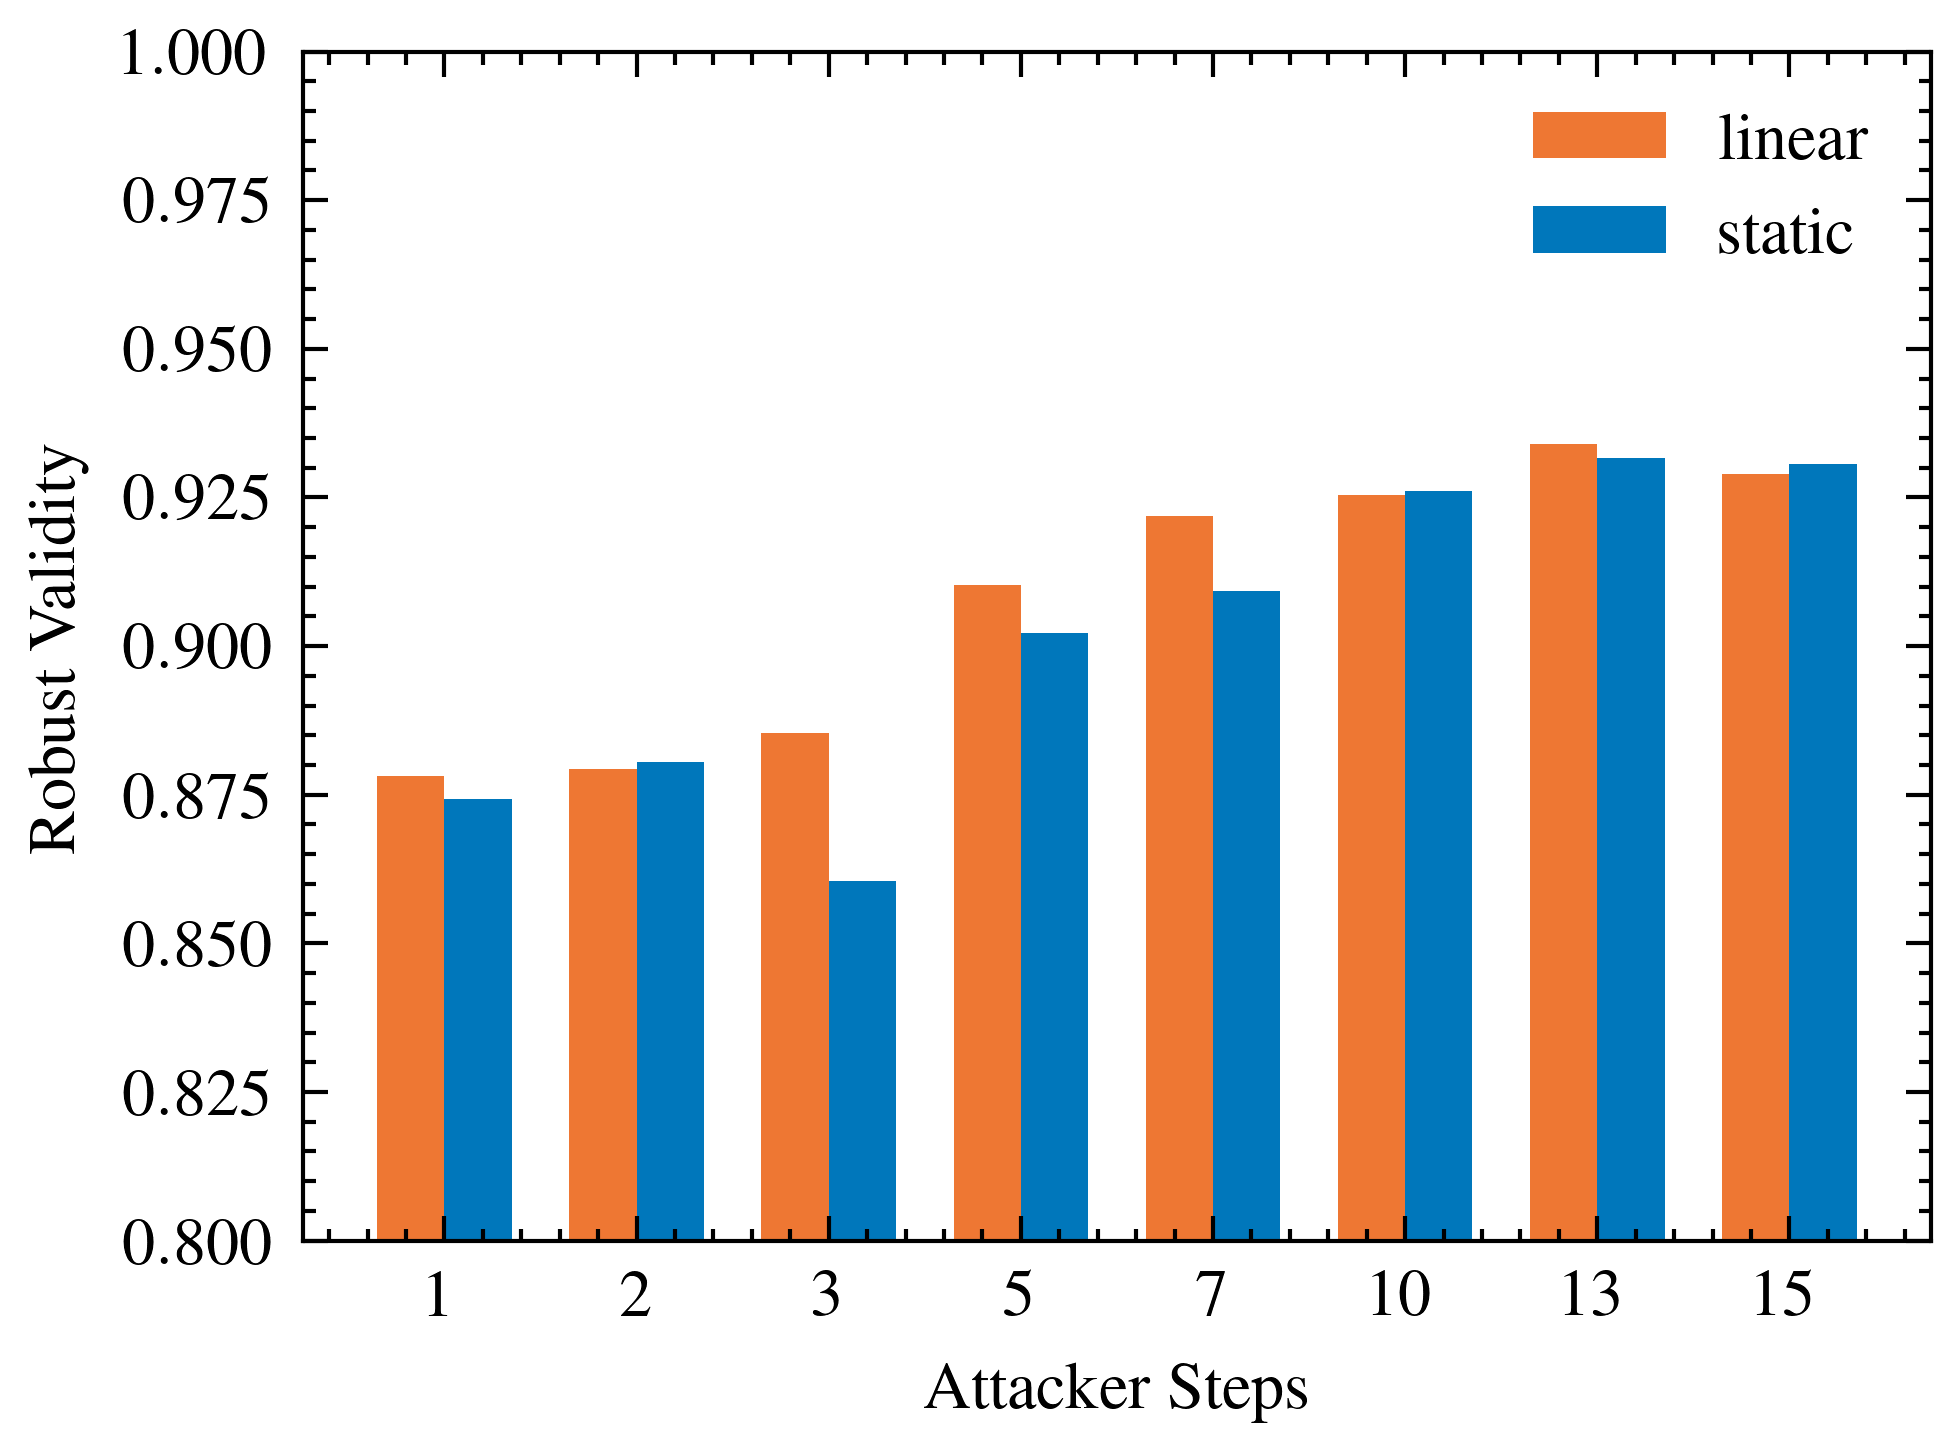

wandb: Network error (ReadTimeout), entering retry loop.


In [17]:
fig = plot_scheduler_comparision(n_steps, validity_changes_linear_dfs, validity_changes_static_dfs)
fig.savefig('images/eps_scheduler.pdf')

In [14]:
fig = plot_scheduler_comparision(
    n_steps, validity_changes_linear_dfs, validity_changes_static_dfs,
    "proximity")
fig.savefig('images/eps_scheduler.pdf')